# Non-Linear Regression In Class Exercise

**Our goals for today:**
- Load peak ground acceleration observations from two notable M6 quakes in California
- Attempt to fit data using `polyfit()`
- Develop a physics-based model and fit to data
- Vary assumed mean event depth to find better fitting model


## Setup

Run this cell as it is to setup your environment.

In [1]:
import math
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Analysis of Strong Ground Motion Data

Earthquakes are the sudden dislocation of rock on opposite sides of a fault due to applied stress. Seismic waves are generated by this process and propagate away from the fault affecting nearby communities. It is the strong shaking from earthquakes that we recognize as the earthquake. These motions can lead to landslides, liquefaction of the ground, and of course impact anything built within or on the ground. The motions generated by fault dislocation affect many aspects of modern society. Earthquake Engineering is a field that studies the ground motions generated by earthquakes and how they affect the built environment. To utilize ground motions for engineering applications requires studying the physics of seismic wave propagation, and the development of models that effectively describe it. Of particular importance is the need to accurately model and predict seismic wave amplitudes. Such studies generally focus on examining the peak acceleration and velocity as a function of distance from the source. The physics indicates that the ground motions generally decrease in amplitude with increasing distance.

On August 24, 2014 a M6 earthquake occurred in south Napa. The following figure shows the observed strong ground acceleration. There is a lot of complexity in the distribution that seismologists and earthquake engineers need to consider, but the general trend is that the ground motions decrease with distance from the earthquake.

<img src="./napa_obsgm.png" width=500>

In this module we will combine acceleration ground motion observations from two M6 events (2014 Napa, and 2004 Parkfield) to have a more complete distance distribution of observations. We will analyze the data first by attempting to fit curves as we have done for other datasets in the class (sea floor age, sea floor magnetism, distance and velocity of supernovae). We will then examine a physics-based model and a variety of methods to fit data. A model that describes the decrease (attenuation) of strong ground motion data over the years has been called 'attenuation relationships', 'ground motion prediction equations (GMPE)' and most recently 'ground motion models (GMM)'. Whatever it is called it is a fundamental to being able to characterized strong ground motion of future earthquakes and is used by the USGS and collaborators to develop earthquake forecast maps. GMM information coupled with the statistics of earthquake occurrence rates, notably Gutenberg-Richter statistics, provides the frame work for characterizing future ground motion hazard, as illustrated in the following map (red is high shaking hazard).

<img src="./2018nshm-longterm.jpg" width=500>

## Part 1, Load, Plot and Fit Models to Peak Ground Acceleration Data

We will make use of peak ground acceleration data from the 2014 Napa and 2004 Parkfield earthquakes. The acceleration is given in units of 'g', where 1g is 981 $\frac{cm}{s^2}$. Earthquake Engineers commonly use the peak ground acceleration in such units in their geotechnical materials and structural engineering analyses. 0.1%g is the level people generally can perceive shaking, at 2%g some people may be disoriented, at 50% the shaking is very violent and unengineered structures can suffer damage and collapse, while well engineered buildings can survive if the duration is short.

In [2]:
#Read the Peak Ground Acceleration data
park_pga=pd.read_csv('parkfieldeq_pga.csv')
napa_pga=pd.read_csv('napaeq_pga.csv')
park_pga.head()

,Dist(km),PGA(g)
0,0.8,0.155
1,2.1,0.276
2,1.2,0.404
3,0.7,0.132
4,3.1,0.230


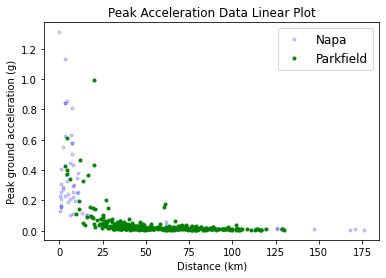

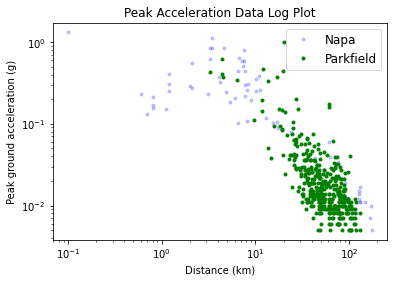

In [3]:
#Plot the two data sets

fig, ax = plt.subplots()
plt.plot(park_pga['Dist(km)'],park_pga['PGA(g)'],'.',color='blue',alpha=0.2)
plt.plot(napa_pga['Dist(km)'],napa_pga['PGA(g)'],'.',color='green')
ax.set(xlabel='Distance (km)', ylabel='Peak ground acceleration (g)',
       title='Peak Acceleration Data Linear Plot')
plt.legend(['Napa','Parkfield'],fontsize=12)
plt.show()

fig, ax = plt.subplots()
plt.loglog(park_pga['Dist(km)'],park_pga['PGA(g)'],'.',color='blue',alpha=0.2)
plt.loglog(napa_pga['Dist(km)'],napa_pga['PGA(g)'],'.',color='green')
ax.set(xlabel='Distance (km)', ylabel='Peak ground acceleration (g)',
       title='Peak Acceleration Data Log Plot')
plt.legend(['Napa','Parkfield'],fontsize=12)
plt.show()

In [4]:
#Combine the two similar magnitude earthquake data
dist=np.concatenate((np.array(napa_pga['Dist(km)']),np.array(park_pga['Dist(km)'])))
pga=np.concatenate((np.array(napa_pga['PGA(g)']),np.array(park_pga['PGA(g)'])))

#Examine individual earthquake data
#dist=np.array(park['Dist(km)'])
#pga=np.array(park['PGA(g)'])

#### First. try fitting the data with standard curves as we did before using np.polyfit()

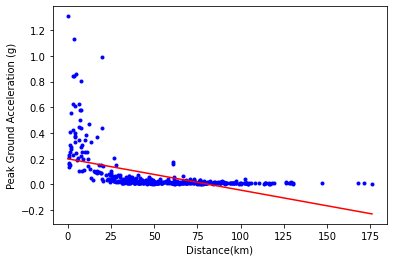

In [5]:
#Try fitting data with np.polyfit()
p=np.polyfit(...)
x=np.arange(0.1,np.max(dist),0.1)
y=np.polyval(p,x)

plt.plot(dist,pga,'.',color='blue')
plt.plot(x,y,'-',color='red')
plt.xlabel('Distance(km)')
plt.ylabel('Peak Ground Acceleration (g)')
plt.show()


#### How well can the data be fit with polynomials?

#### Try fitting the data with a power law ($pga = \frac{a}{dist^b}$)

- To do this we linearize the equation to use polyfit() for a line

[-0.9952347 -0.0412993]


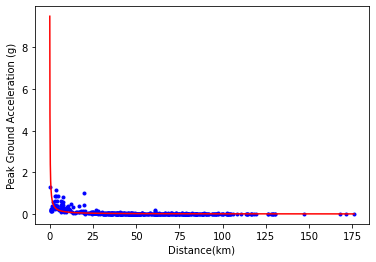

In [6]:
#dist=dist+1    #add a small number to avoid singularity (dist=0)
p=np.polyfit(...)
print(p)
x=np.arange(np.min(dist),np.max(dist),0.1)
y=np.polyval(p,np.log(x))

#dist=dist-1
plt.plot(dist,pga,'.',color='blue')
plt.plot(x,np.exp(y),'-',color='red')
plt.xlabel('Distance(km)')
plt.ylabel('Peak Ground Acceleration (g)')
plt.show()

#### How well does a power law fit?

What is wrong with this function?

## Part 2, Fitting Strong Motion Data

In order to use the observations of peak ground acceleration to characterize seismic ground motion hazard it is necessary to develop a model that accurately describes the behavior seismic wave propagation, for example how the waves travel through the earth and dissipate. From physics seismic ground motions decay as a power law with distance (referred to as geometrical spreading), but we saw earlier that a power law alone does not work well, it is linear in log-space, where it does not explain the plateauing of ground motions close to the earthquake.

To fix this we also need to consider that waves travel upward as well as away from an earthquake where
$r=\sqrt{(dist^2 + h^2)}$ is the total distance comprised of the horizontal distance and the depth (h) of the earthquake.

Finally, in addition to geometrical spreading, there is an inelastic attenuation term that accounts for dissipative energy loss due to material imperfections. Based on this theory the following is a simple relationship that describes the dissipation or attenuation of seismic wave energy with distance from the earthquake, 

$pga=a*{\frac{1}{r^b}}*e^{cr}$,

where $a$ is a coeffient that depends on magnitude and scales the overall motions, $b$ is the exponent for the power-law geometrical spreading term, and $c$ is the coefficient for the in-elastic term (important only at large distances), and r is the total distance that considers the depth of the earthquake (h). Note that in the far-field the theoretical geometrical spreading decay of ground motions is ~1/r (in the near-field it is ~$1/r^2$). This is a non-linear equation, but it can be linearized by taking the natural logarithm.

$\mathrm{ln}(pga)=a + b*\mathrm{ln}(r) + c*r$

- How do we setup this inverse problem? Let's first consider a simple linear example.

### How to setup a linear (linearized) inverse problem

- Until now we have been using "canned" functions to fit lines, or polynomials to data, but this doesn't always work because 1) sometimes more complicated functions are needed, 2) functions are non-linear, 3) we need to fit a physics-based model to the data.

- We can construct our own inverse problem to fit more complex functions, as illustrated below.

- When fitting a model such as a line to data, each data point can be considered a separate equation of two variables (a, b). That is for each x value there is a corresponding y value related to x through the equation for a line, where a is the intercept and b is the slope of the line. 

<img style="right;" src="./linear_eq_cartoon.png" width="500">

- The system of equations can be constructed in matrix form, and least squares (or other methods may be used to solve the matrix equation for the model parameters. Some of the functions we have been using are doing this "under the hood".

#### Let's try it for a simple linear case

1. Consider data from a line with some random noise added
2. Fit data using polyfit()
3. Construct the linear inverse problem from basic principles
4. Apply non-linear least-squares scipy.optimize.curve_fit()

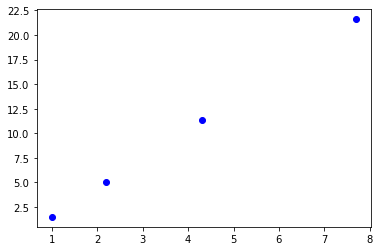

From polyfit(): a=-1.50  b=3.00


In [4]:
x=np.array((1, 2.2, 4.3, 7.7))
data=-1.5 + 3*x                   #construct data with an intercept of -1.5 and slope of 3.

#random number array
#rand=np.random.uniform(low=-2., high=2.0, size=4)    #apply random numbers
#data=data + rand

m=np.polyfit(x,data,1)

plt.plot(x,data,'o',color='blue')
#syn=np.polyval(m,x)
#plt.plot(x,syn,'-',color='red')
plt.show()

print(f'From polyfit(): a={m[1]:.2f}  b={m[0]:.2f}')

#Solve via least squares
A=np.vstack((...,...)).transpose()
#AtA=np.dot(...)
#AtD=np.dot(...)
#a, b=np.linalg.solve(...)
#print(f'From manual least squares: a={a:.2f}  b={b:.2f}')

#Now lets use the scipy non-linear least-squares curve_fit() method
#def linmod(x,a,b):
#    return ...

#m=curve_fit(linmod,x,data)[0]
#print(f'From curve_fit(): a={m[0]:.2f}  b={m[1]:.2f}')





### Now Setup a lineared inverse problem for the PGA data

(a,b,c)=1.820/-1.615/0.010  RMS=0.113


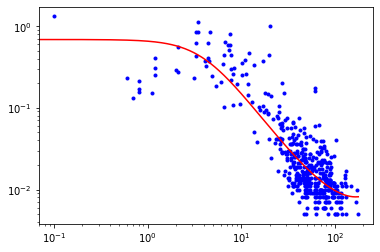

In [8]:
#Setup a linearized inverse problem for Parkfield
h=4.0  #Assume a depth (km)
r=np.sqrt(dist**2 + h**2)

#Setup G matrix
intercept_term=
ln_term=
exp_term=
G=

#Setup Data Matrix
d=

#Setup of least squares
gtg=np.dot(...)
gtd=np.dot(...)

#Solve for a, b, c
a, b, c=np.linalg.solve(gtg,gtd)

#Measure fit
m=np.array((a,b,c))
syn=np.exp(a + b*np.log(r) + c*r)
rms_fit=np.sqrt(np.mean((pga - syn)**2))
print(f'(a,b,c)={a:.3f}/{b:.3f}/{c:.3f}  RMS={rms_fit:.3f}')

#Plot results
x=np.arange(0.0,np.max(dist),0.1)
xr=np.sqrt(x**2 + h**2)
y=np.exp(a + b*np.log(xr) + c*xr)
plt.loglog(dist,pga,'.',color='blue')
plt.loglog(x,y,'-',color='red')
plt.show()



#### How well does this inversion perform? Are the model parameters consistent with the theory for geometrical spreading and anelastic attenuation?

- write answer here

## Part 3, Apply Non-linear least-squares

The model that we are trying to fit is non-linear in distance so it makes sense to try the non-linear least-squares method. We will also discover that with this optimization method we can find solution with a assumed range of parameters that can be constraint by our understanding of the physics or by some other observations.

Non-linear optimization is a topic that requires an entire semester by itself, and would include non-linear least-squares, grid-search (though slow for large data sets), Montecarlo sampling, Bayesian inference, genetic algorithm, etc.

We will use the scipy.optimization.curve_fit() which utilizes non-linear least squares. So that this is not entirely a black box, briefly non-linear least-squares involves using a starting model to estimate a prediction error, differentiating the prediction error with respect to model parameters, and then updating the model and repeating until convergence is achieved. This wiki describes it in some detail. https://en.wikipedia.org/wiki/Non-linear_least_squares

If $y$ is the data and $f(x, m)$ is the prediction as a function of (m) model parameters then the initial prediction error is $e_i=(y_i - f(x_i, m_0))$. Given an initial model $m_0$, $f$ can be represented as a Taylor series where $f(x_i, m_1)=f(x_i, m_0) + \frac{\partial f}{\partial m}(m_1 - m_0)$=$f(x_i, $m_0$) + \frac{\partial f}{\partial m}(\Delta m)$=$y_i$. Combining the prediction error and Taylor series equations gives:

$e_i=[\frac{\partial f}{\partial m}](\Delta m)$, which as the form of the previous matrix equation we used. Suppose m=(a,b), and f(m)=a+bx then this results in a system of equations:

$e_1=\frac{\partial f}{\partial a}\rvert_{x_1}\Delta a + \frac{\partial f}{\partial b}\rvert_{x_1}\Delta b$

$e_2=\frac{\partial f}{\partial a}\rvert_{x_2}\Delta a + \frac{\partial f}{\partial b}\rvert_{x_2}\Delta b$

$e_N=\frac{\partial f}{\partial a}\rvert_{x_N}\Delta a + \frac{\partial f}{\partial b}\rvert_{x_N}\Delta b$

If $m_0$=(0,0) then the system of equations becomes what we found for the linear least-squares problem, where:

$y_1=a + bx_1$

$y_2=a + bx_2$

$y_N=a + bx_N$

The following is the general non-linear least-squares equation:
\begin{equation*}
Y=
\begin{bmatrix}
\frac{\partial f}{\partial m_1}\rvert_{x_1} & \frac{\partial f}{\partial m_1}\rvert_{x_1} & \cdots & \frac{\partial f}{\partial m_M}\rvert_{x_1} \\
\frac{\partial f}{\partial m_1}\rvert_{x_2} & \frac{\partial f}{\partial m_1}\rvert_{x_2} & \cdots &\frac{\partial f}{\partial m_M}\rvert_{x_2} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f}{\partial m_1}\rvert_{x_N} & \frac{\partial f}{\partial m_1}\rvert_{x_N} & \cdots & \frac{\partial f}{\partial m_M}\rvert_{x_N}
\end{bmatrix}
\quad
\begin{bmatrix}
\Delta m_1 \\
\Delta m_2 \\
\vdots \\
\Delta m_M
\end{bmatrix}
\end{equation*}



(a,b,c,h)=1.006/-1.243/-0.001  RMS=0.110


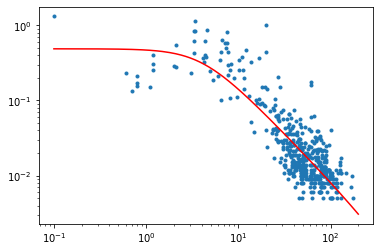

In [9]:
#Test the scipy curve_fit method

#Define the non-linear function
def gm_model(x,a,b,c):
    #This function returns ln(pga)
    return ...

h=4.0
r=np.sqrt(dist**2 + h**2)
m=curve_fit(...,..., ...,bounds=([...,...,...],...))[0]

#Measure fit
syn=np.exp(gm_model(r,m[0],m[1],m[2]))
rms_fit=np.sqrt(np.mean((pga - syn)**2))
print(f'(a,b,c,h)={m[0]:.3f}/{m[1]:.3f}/{m[2]:.3f}  RMS={rms_fit:.3f}')

plt.loglog(dist,pga,'.')
x=np.arange(0.1,200,0.1)
xr=np.sqrt(x**2 + h**2)
y=np.exp(gm_model(xr,m[0],m[1],m[2]))
plt.loglog(x,y,'-',color='red')
plt.show()

### Compute 95% confidence intervals

In [10]:
#Compute 95% confidence levels
degfree=len(r)-3                           #degrees of freedom (num data - num model params)
e=np.log(pga)-np.log(syn)                  #residuals between data and model
var=np.sum(e**2)/degfree                   #variance
se_y=np.sqrt(var)                          #standard error of the estimate
sdev=np.sqrt(var)                          #standard deviation
#Calculate 95% confidence bounds
t=stats.t.ppf(1-0.05/2,degfree)             #division by 2 to map from single-tail to dual-tail t-distribution
lower95=np.exp(np.log(y)-t*se_y)
upper95=np.exp(np.log(y)+t*se_y)

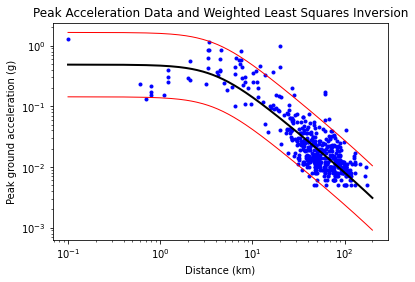

In [11]:
#Plot Results
fig, ax = plt.subplots()
ax.loglog(dist,pga,'b.',x,y,'k-',linewidth=2)
ax.loglog(x,lower95,'r-',x,upper95,'r-',linewidth=1)
ax.set(xlabel='Distance (km)', ylabel='Peak ground acceleration (g)',
       title='Peak Acceleration Data and Weighted Least Squares Inversion')
#plt.legend(['Napa','Parkfield'],fontsize=12,loc=3)
plt.show()


#### Test our assumption that the mean depth of the earthquakes is 4.0km.


What depth produces the best fitting model (minimum variance)? How sensitive is the model to depth? Consider depths ranging from say 1 to 20 km.

_Write your answer here._

#### Compare solutions using the Napa and Parkfield data separately and discuss how the results compare.

Write you answer here.